# Bootstrap particle filter

Notebook about testing the implementation of bootstrap particle filter.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os
import sys

# Add parent directory to sys.path
print(os.getcwd())
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(parent_dir)

d:\School\Fakulteta\2. stopnja\2. letnik\Master\notebooks


In [2]:
from src.models.mssv import MSSVModelParams, MSSVModel
from src.filters.smc.bootstrap_pf import BootstrapParticleFilter
from src.filters.smc.resampling import systematic_resampling

In [3]:
# Set random seed for reproducibility
rng = np.random.default_rng(42)

# True parameters
theta = MSSVModelParams(
    mu=[-1.0, 1.0],
    phi=[0.95, 0.95],
    sigma_eta=[0.2, 0.3],
    P=[[0.95, 0.05],
        [0.05, 0.95]]
)

# Initialize model
model = MSSVModel(rng=rng)

In [4]:
# Function to simulate data from the MSSV model.
# TODO: Implement synthetic data generation in data/synthetic
def simulate_mssv(model, theta, T, rng):
    states = []
    observations = []

    state = model.sample_initial_state(theta)
    for _ in range(T):
        state = model.sample_transition(theta, state)
        h_t, _ = state
        y_t = rng.normal(0.0, np.exp(0.5 * h_t))

        states.append(state)
        observations.append(y_t)

    return states, np.array(observations)

In [5]:
# Simulate data
T = 300
true_states, y = simulate_mssv(model, theta, T, rng)

In [6]:
# Run particle filter
pf = BootstrapParticleFilter(model, n_particles=1000, resampler=systematic_resampling)
history = pf.run(y, theta)

In [7]:
h_true = np.array([h for h, s in true_states])
s_true = np.array([s for h, s in true_states])

T = len(history)
N = len(history[0][0])
K = len(theta.mu)  # number of regimes

print("Number of time steps:", T)
print("Number of particles:", N)
print("Number of regimes:", K)

Number of time steps: 300
Number of particles: 1000
Number of regimes: 2


In [15]:
def weighted_HDI(particles, weights, cred_mass=0.95):
    """
    Compute the Highest Density Interval (HDI) for a weighted set of samples.

    Args:
        particles (np.ndarray): 1D array of particle values (e.g., h_t)
        weights (np.ndarray): Normalized weights corresponding to particles
        cred_mass (float): Desired posterior mass (default 0.95)

    Returns:
        h_mean (float): Weighted mean
        h_median (float): Weighted median
        h_HDI (tuple): (lower_bound, upper_bound) of HDI
    """
    particles = np.array(particles)
    weights = np.array(weights)
    assert np.isclose(weights.sum(), 1.0), "Weights must be normalized"

    # Weighted mean
    h_mean = np.sum(particles * weights)

    # Weighted median
    sorted_idx = np.argsort(particles)
    particles_sorted = particles[sorted_idx]
    weights_sorted = weights[sorted_idx]
    cum_weights = np.cumsum(weights_sorted)
    median_idx = np.searchsorted(cum_weights, 0.5)
    h_median = particles_sorted[median_idx]

    # HDI computation
    # Sort particles by descending weight density
    # For particles with unique values, sort by particle value and slide window
    # Step 1: sort by particle value
    sorted_idx = np.argsort(particles_sorted)
    particles_sorted = particles_sorted[sorted_idx]
    weights_sorted = weights_sorted[sorted_idx]
    cum_weights = np.cumsum(weights_sorted)

    # Step 2: slide a window to find narrowest interval containing cred_mass
    n = len(particles_sorted)
    intervals = []
    for start in range(n):
        # Find end index such that cumulative weight difference >= cred_mass
        target = cum_weights[start] + cred_mass
        end_idx = np.searchsorted(cum_weights, target)
        if end_idx < n:
            intervals.append((particles_sorted[start], particles_sorted[end_idx]))

    if len(intervals) == 0:
        # fallback to min/max
        h_HDI = (particles_sorted[0], particles_sorted[-1])
    else:
        # choose interval with minimal width
        h_HDI = min(intervals, key=lambda x: x[1]-x[0])

    return h_mean, h_median, h_HDI


In [8]:
# Extract particles and weights as arrays
particles_array = np.array([ [p for p in history[t][0]] for t in range(T) ])  # shape (T, N, 2)
weights_array = np.array([ history[t][1] for t in range(T) ])                 # shape (T, N)

In [21]:
h_mean_all = []
h_median_all = []
h_HDI_all = []

s_median_all = []

for t in range(T):
    h_t = [p[0] for p in history[t][0]]
    weights_t = history[t][1]
    mean, median, HDI = weighted_HDI(h_t, weights_t, cred_mass=0.95)
    h_mean_all.append(mean)
    h_median_all.append(median)
    h_HDI_all.append(HDI)

    s_t = [p[1] for p in history[t][0]]
    mean, median, HDI = weighted_HDI(s_t, weights_t, cred_mass=0.95)
    s_median_all.append(median)

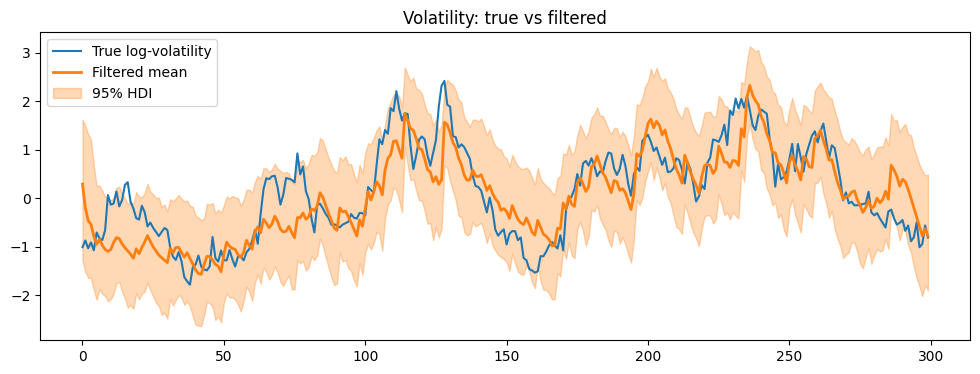

In [22]:
# Plot graph of true vs estimated log volatility
plt.figure(figsize=(12, 4))
plt.plot(h_true, label="True log-volatility")
plt.plot(h_mean_all, label="Filtered mean", linewidth=2)
plt.fill_between(range(T),
                 [h_HDI_all[t][0] for t in range(T)],
                 [h_HDI_all[t][1] for t in range(T)],
                 color='C1', alpha=0.3, label="95% HDI")
plt.legend()
plt.title("Volatility: true vs filtered")
plt.show()

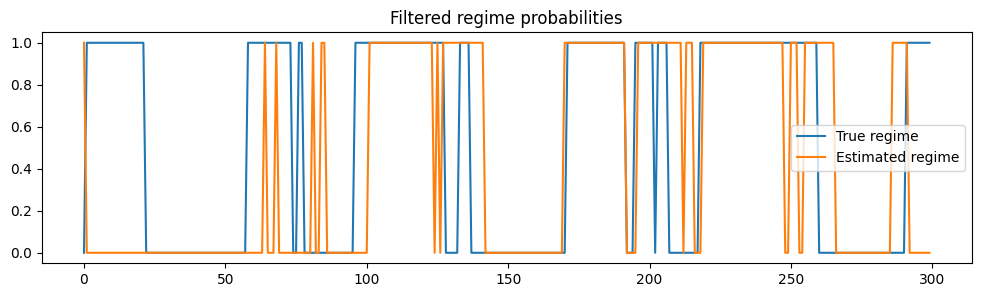

In [23]:
# Plot graph of true vs estimated regimes
plt.figure(figsize=(12, 3))
plt.plot(s_true, label="True regime")
plt.plot(s_median_all, label="Estimated regime")
plt.legend()
plt.title("Filtered regime probabilities")
plt.show()

In [28]:
# Run same process with different number of particles
results = {}
for n_particles in [10, 50, 100, 500, 1000, 2000]:
    print(f"Running particle filter with N={n_particles} particles...")
    pf = BootstrapParticleFilter(model, n_particles=n_particles, resampler=systematic_resampling)
    history = pf.run(y, theta)

    h_mean_all = []
    h_HDI_all = []
    s_median_all = []
    for t in range(T):
        # Extraction for h_t
        h_t = [p[0] for p in history[t][0]]
        weights_t = history[t][1]
        mean, median, HDI = weighted_HDI(h_t, weights_t, cred_mass=0.95)
        h_mean_all.append(mean)
        h_HDI_all.append(HDI)

        # Extraction for s_t
        s_t = [p[1] for p in history[t][0]]
        mean, median, HDI = weighted_HDI(s_t, weights_t, cred_mass=0.95)
        s_median_all.append(median)
    
    results[n_particles] = {
        "h_mean": h_mean_all,
        "h_HDI": h_HDI_all,
        "s_median": s_median_all
    }

Running particle filter with N=10 particles...
Running particle filter with N=50 particles...
Running particle filter with N=100 particles...
Running particle filter with N=500 particles...
Running particle filter with N=1000 particles...
Running particle filter with N=2000 particles...


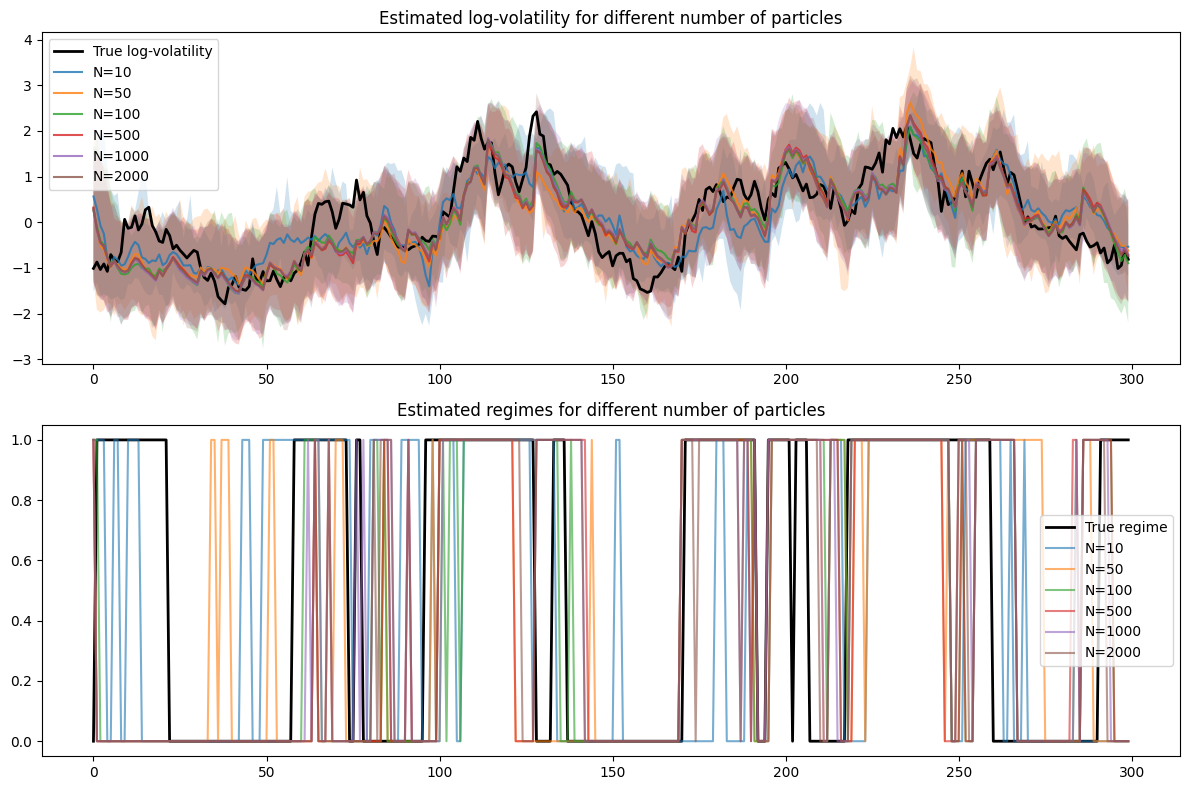

In [42]:
# Plot estamates and true values for different number of particles
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(h_true, label="True log-volatility", color='black', linewidth=2)
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(s_true, label="True regime", color='black', linewidth=2)
plt.legend()

for n_particles, result in results.items():
    plt.subplot(2, 1, 1)
    plt.plot(result["h_mean"], label=f"N={n_particles}", alpha=0.8)
    plt.fill_between(range(T),
                     [result["h_HDI"][t][0] for t in range(T)],
                     [result["h_HDI"][t][1] for t in range(T)],
                     alpha=0.2)
    plt.title("Estimated log-volatility for different number of particles")
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(result["s_median"], label=f"N={n_particles}", alpha=0.6)
    plt.title("Estimated regimes for different number of particles")
    plt.legend()

plt.tight_layout()
plt.show()

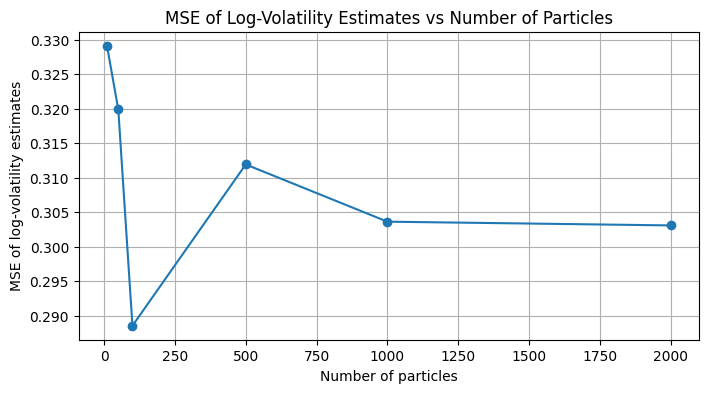

In [31]:
# Plot MSE for log-volatility estimates vs number of particles
mse_h = []
n_particles_list = [10, 50, 100, 500, 1000, 2000]
for n_particles in n_particles_list:
    h_est = results[n_particles]["h_mean"]
    mse = np.mean((h_true - h_est) ** 2)
    mse_h.append(mse)

plt.figure(figsize=(8, 4))
plt.plot(n_particles_list, mse_h, marker='o')
plt.xlabel("Number of particles")
plt.ylabel("MSE of log-volatility estimates")
plt.title("MSE of Log-Volatility Estimates vs Number of Particles")
plt.grid(True)
plt.show()

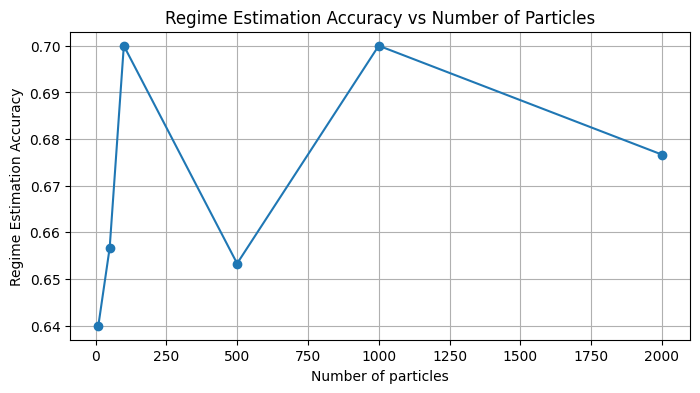

In [32]:
# Compute accuracy of regime estimates vs number of particles
accuracy_s = []
for n_particles in n_particles_list:
    s_est = results[n_particles]["s_median"]
    accuracy = np.mean(s_true == s_est)
    accuracy_s.append(accuracy)

# Plot accuracy vs number of particles
plt.figure(figsize=(8, 4))
plt.plot(n_particles_list, accuracy_s, marker='o')
plt.xlabel("Number of particles")
plt.ylabel("Regime Estimation Accuracy")
plt.title("Regime Estimation Accuracy vs Number of Particles")
plt.grid(True)
plt.show()